# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

Fuente: https://github.com/Yangyangii/GAN-Tutorial


In [1]:
# Run the comment below only when using Google Colab
#!pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_8/GANs'

Mounted at /content/drive


In [7]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        # primero preparamos una FC para llevar la cosa a una imagen de [batchx512x4x4]
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        # y despues se arma una capa de de-convolución
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)           # vectorizamos la entrada (por si no esta vectorizada?)
        y_ = self.fc(x)                     # primera capa (FC)
        y_ = y_.view(y_.size(0), 512, 4, 4) # damos formato a su salida [batchx512x4x4]
        y_ = self.conv(y_)                  # la pasamos por la capa CONV
        return y_

In [9]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y=None):
        y_ = self.conv(x)   # pasamos la imagen de entrada por la CONV
        y_ = y_.view(y_.size(0), -1) # vectorizamos la salida de la CONV
        y_ = self.fc(y_) # la pasamos por la última FC
        return y_

In [10]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [11]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)


In [12]:
G.load_state_dict(torch.load(data_dir + '/cG.pkl', map_location=DEVICE, weights_only=False))

<All keys matched successfully>

In [13]:
D.load_state_dict(torch.load(data_dir + '/cD.pkl', map_location=DEVICE, weights_only=False))

<All keys matched successfully>

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [15]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.3MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.85MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [16]:
batch_size = 64

In [17]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [19]:
max_epoch = 100 # need more than 20 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [20]:
D_true = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to true
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [21]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_true)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_true)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.3932996988296509, G Loss: 0.6694718599319458
Epoch: 0/100, Step: 500, D Loss: 0.8431456089019775, G Loss: 1.3850387334823608
Epoch: 1/100, Step: 1000, D Loss: 0.7042579650878906, G Loss: 1.2319872379302979


KeyboardInterrupt: 

## Sample

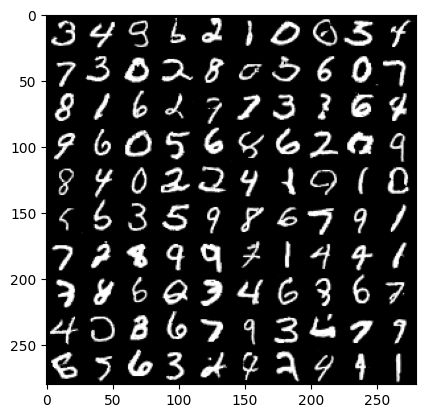

In [22]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [23]:
# Saving params.
#torch.save(D.state_dict(), data_dir + '/cD.pkl')
#torch.save(G.state_dict(), data_dir + '/cG.pkl')

In [24]:
def get_sample_image_col(G, n_noise, z):
    """
        save sample 100 images
    """

    # lo repito 100 veces para generas 100 imagenes
    z2 =  z.repeat(100, 1)

    # defino un spam de valores para reemplazar en una columna
    # recuerdo que mi generador es una randn (distribución normal con media=0 y varianza=1)
    # por lo que en -3 a +3 tendré el 99.9% de los valores que pude haber visto el G
    a = torch.linspace(-3,3,100)

    # elejir que columna deseo reemplazar
    # lo la cambio a azar
    n = np.random.randint(n_noise)
    print(f'Columna variada: {n}')
    z2[:,n] = a

    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z2).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [25]:
z = torch.randn(1, n_noise).to(DEVICE) # genero un batch de 1 vector randn
                                            # del tamaño definido en n_noise.

Columna variada: 59


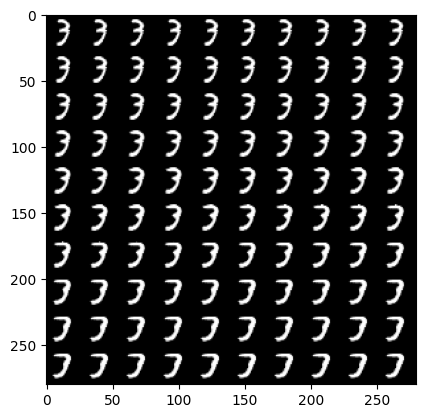

In [26]:
imshow(get_sample_image_col(G, n_noise, z), cmap='gray')